# Creating and Testing a Gabor Kernel Classifier and Convolutional Neural Network on a Subset of the MNIST Dataset

## Imports

In [15]:
!pip install fastai

In [16]:
#imports
from fastai.vision.all import *
from keras.datasets import mnist #handwritten digit dataset

import numpy as np
import pandas as pd
import sklearn
from scipy import ndimage as ndi #convolution method
from skimage.filters import gabor_kernel
from sklearn.ensemble import RandomForestClassifier #RF classifier for gabor features
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Gabor Kernel Image Classifier

In [17]:
#load images into proper numpy arrays
(train_X, train_y), (test_X, test_y) = mnist.load_data()

#take a subset of the dataset, as 60000 images takes too long to train
#for this algorithm, 1000 training images and 200 testing images are used
train_X = train_X[0:1000,:,:]
test_X = test_X[0:200,:,:]
train_y = train_y[0:1000]
test_y = test_y[0:200]

#normalize pixel values
train_X = train_X / 255.0
test_X = test_X / 255.0

In [18]:
#create function to extract features using Gabor kernels
def get_feats(train_X):

    #dataset containing all extracted features from ALL images
    feature_dataset = pd.DataFrame()

    num_x = train_X.shape[0]

    #loop through each image
    for x in range(num_x):

        #dataset containing features for a SINGLE image
        x_features = pd.DataFrame()
        x_img = train_X[x,:,:]

        #add the original image as the first feature
        og_pixel_values = x_img.reshape(-1)
        x_features['og_pixel_values'] = og_pixel_values

        kernels = []
        counter = 1
        #loop through each gabor kernel
        for theta in (0, np.pi/2, np.pi, (3/2)*np.pi):
            for lam in (0,1,2):
                for sigma in (0.25, 0.5, 1):

                    #define gabor kernel
                    gabor_k = gabor_kernel(frequency=lam, theta=theta, sigma_x=sigma, sigma_y=sigma)

                    #take the real part of the gabor function output
                    gabor_k = np.real(gabor_k)
                    kernels.append(gabor_k)

                    #convolve image with the current gabor kernel
                    x_filtered = ndi.convolve(x_img, gabor_k, mode='nearest')
                    x_filtered = x_filtered.reshape(-1)

                    #add newest feature to the dataset containing features for that specific image
                    x_features[f"Gabor {counter}"] = x_filtered

                    counter += 1

        #add the dataset of features of the CURRENT image to ...
        #the datset of features of ALL images
        feature_dataset = pd.concat([feature_dataset, x_features])
    return feature_dataset

In [19]:
#obtain all features from the training dataset
features = get_feats(train_X)

#reshape 3-dimensional feature matrix so that it can fed into a random forest classifier
image_features = np.expand_dims(features, axis=0)
train_X_reshaped = np.reshape(image_features, (train_X.shape[0], -1))

#define model
model = RandomForestClassifier(n_estimators = 25, random_state = 42)

#fit/train model
model.fit(train_X_reshaped, train_y)

#repeat feature extraction and reshape steps with testing images
test_features = get_feats(test_X)
test_features = np.expand_dims(test_features, axis=0)
test_X_reshaped = np.reshape(test_features, (test_X.shape[0], -1))

#predict the classes of the test images
test_prediction = model.predict(test_X_reshaped)

In [20]:
#compute and print test accuracy
acc = metrics.accuracy_score(test_y, test_prediction)
print(f"Gabor kernel image classifier accuracy: {acc}")

Gabor kernel image classifier accuracy: 0.915


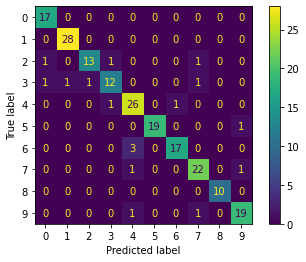

In [21]:
#render a confusion matrix for the Gabor kernel classifier
cm = confusion_matrix(test_y, test_prediction)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## Convolutional Neural Network

In [27]:
path = './MNIST_sample'

In [29]:
#set up datablock and dataloaders from image files
#see save_MNIST_as_images.ipynb for more info
set_seed(123,True)
mnist_block = DataBlock(
       blocks=(ImageBlock, CategoryBlock),
       get_items=get_image_files,
       splitter=GrandparentSplitter(train_name="train", valid_name="test"),
       get_y=parent_label)

dls = mnist_block.dataloaders(path)

#train CNN
#number of epochs and learning rate were manipulated to get a good result
#the final accuracy is shown in the accuracy column, at the final epoch (9)
learner = vision_learner(dls, resnet18, metrics=accuracy)
learner.fine_tune(epochs=10,  base_lr=9e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.479373,2.130881,0.320000,00:08


epoch,train_loss,valid_loss,accuracy,time
0,1.025809,1.166076,0.620000,00:14
1,0.725899,0.794271,0.770000,00:13
2,0.527175,0.489473,0.835000,00:14
3,0.396135,0.374917,0.895000,00:34
4,0.301593,0.308520,0.925000,00:15
5,0.253714,0.381935,0.915000,00:14
6,0.197935,0.290132,0.920000,00:13
7,0.152422,0.285283,0.930000,00:35
8,0.116248,0.285550,0.935000,00:15
9,0.089860,0.288679,0.930000,00:14


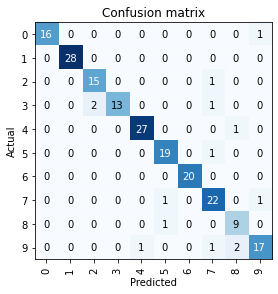

In [30]:
#render a confusion matrix for the CNN
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()